Отрисовка модельных изображений:

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm
import scipy.fft as sfft
import scipy.fftpack as sfftp
import scipy.signal as sgnl

In [19]:
def SaveLines1 (N = 512, npoints = 3, nimages = 1, wd = 10):
    for i in range(1, nimages+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        points = np.random.randint(0, N, 2*npoints)
        idraw.line(xy=tuple(points), fill='white', width=wd)
        s = 'lines_(' + str(i) + ').png'
        img.save(s)

def SaveSircles (N = 512, ns = 3):
    img = Image.new('1', (N, N), 'white')
    ns = 4*ns
    idraw = ImageDraw.Draw(img)
    for j in range(0, ns//2):
        k = 2*j*N//ns
        idraw.ellipse( (k, k, N-k, N-k), 'black', 'black')
        k = (2*j+1)*N//ns
        idraw.ellipse( ((k, k, N-k, N-k)), 'white', 'white')
    img.save('sircles.png')

In [30]:
N = 512 #разрешение изображений
n_points = 4
n_images = 6  #количество слоев

line_width = 5
n_sircles = 60

dz = 200

In [23]:
def SaveLines (N = 512, nimages = 1):
    for i in range(1, n_images+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        idraw.line((i*N/(n_images+1), 0, i*N/(n_images+1), N), fill='white', width=15)
        s = 'lines_' + str(i) + '.png'
        img.save(s)

In [57]:
def SaveSectors (N = 512, n_points = 5):
    for i in range(1, n_images+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        for j in range(1, n_points+1):
            idraw.pieslice(xy=(10, 10, N-10, N-10), 
                           start=360/(n_points)*(j-1) + 10*i, 
                           end=180/(n_points)*(2*j-1) + 10*i, 
                           fill='white', outline='black')
        s = 'sectors_' + str(i) + '.png'
        img.save(s)

In [58]:
SaveSectors(N = 512, n_points = 5)

In [71]:
SaveLines(512, 6)

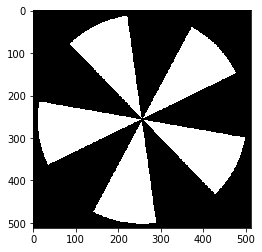

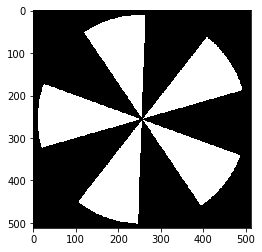

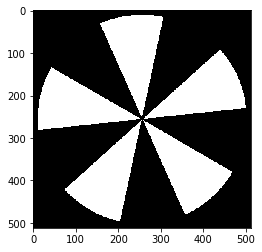

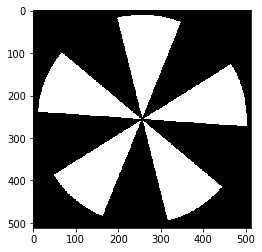

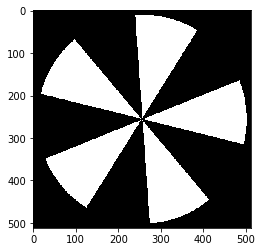

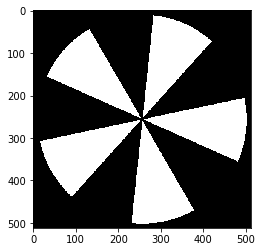

In [59]:
for i in range (1, n_images+1):
    plt.imshow(Image.open("sectors_" + str(i) + ".png"), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    plt.show()

Функция рассеяния точки:

In [4]:
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны

In [5]:
def M(x, y):                      #функция зрачка
    if (x*x + y*y) < r*r:
        return 1.0
    else:
        return 0.0

def dnm(dz):
    return dz*r/f*r/2/f

def ps(x, y, dz):
    return dnm(dz)*(x*x + y*y)/r/r*2*cm.pi/L

def p(x, y):
    return 0.5*cm.pi*(x*x + y*y)

def h(dz):
    arr = np.empty((N, N), dtype="complex")
    for i in range (0, N):
        for k in range (0, N):
            x = 2*i*cm.pi/N - cm.pi
            y = cm.pi - 2*k*cm.pi/N
            arr[i, k] = M(x, y) * cm.exp(1j*ps(x, y, dz) + 1j*p(x, y))
    arr = sfft.fft2(arr)    #дискретное двумерное преобразование Фурьe
    arr = sfftp.fftshift(arr)
    g = np.empty((N, N), dtype="double")
    for i in range (0, N):
        for k in range (0, N):
            g[i, k] = (cm.polar(arr[i, k])[0])**2
    m = np.amax(g)
    g = g/m
    return g

In [6]:
dz = 75                           #(микрон) расстояние между слоями

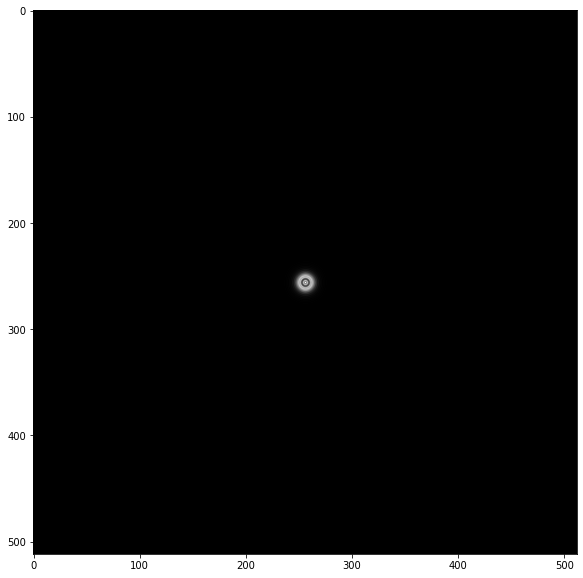

In [7]:
h1 = h(dz)
plt.figure(figsize=(10, 10))
plt.imshow(h1, cmap='gray', vmin=0, vmax=1)
plt.show()

Свертка напрямую:

In [7]:
def conv(image_number, dz):
    im = Image.open("lines_" + str(image_number) + ".png")
    res = sgnl.convolve2d(np.asarray(im), h(dz), mode='full', boundary='fill', fillvalue=0)
    return res

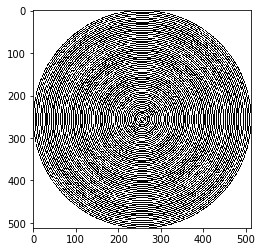

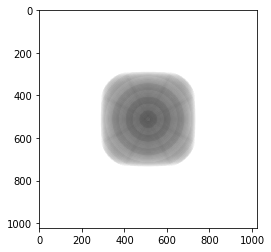

In [8]:
dz = 75
im_s = Image.open("sircles.png")
res_s = sgnl.convolve2d(np.asarray(im_s), h(dz), mode='full', boundary='fill', fillvalue=255)

plt.imshow(im_s, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(res_s, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

Теорема о свертке и преобразования Фурье:

In [72]:
def conv_F(image_number, dz):
    im = Image.open("lines_" + str(image_number) + ".png")
    im_F = sfftp.fftshift(sfft.fft2(np.asarray(im)))
    h_F = sfftp.fftshift(sfft.fft2(h(dz)))
    res_F = im_F*h_F
    res = np.abs(sfftp.ifftshift(sfft.ifft2(res_F)))
    return res

Свертки одного слоя с функциями рассеяния для различных dz:

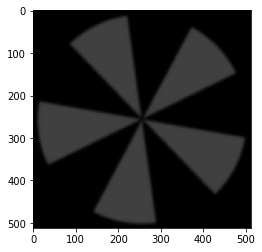

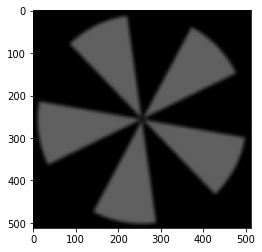

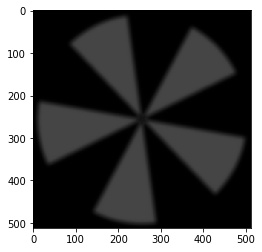

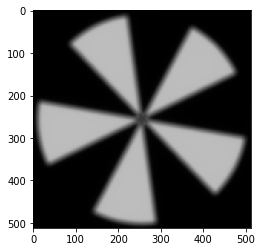

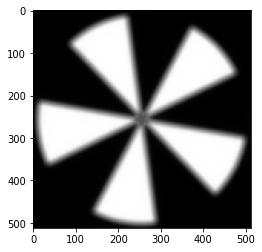

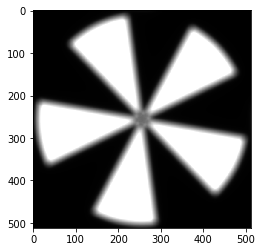

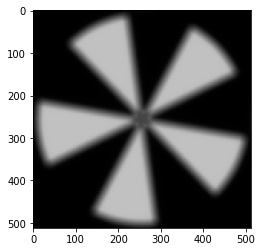

In [68]:
dz = 25
for i in range (0, n_images+1):
    res = conv_F(1, dz*i)
    plt.imshow(res, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    plt.show()

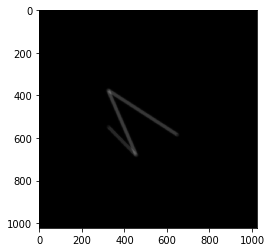

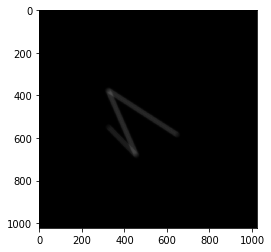

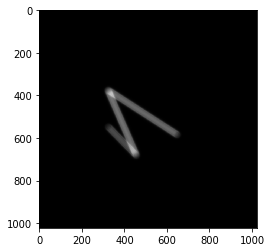

In [9]:
for i in range (1, n_images+1):
    res = conv(n_images, dz*i)
    plt.imshow(res, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    plt.show()

Построение наблюдаемых изображений:

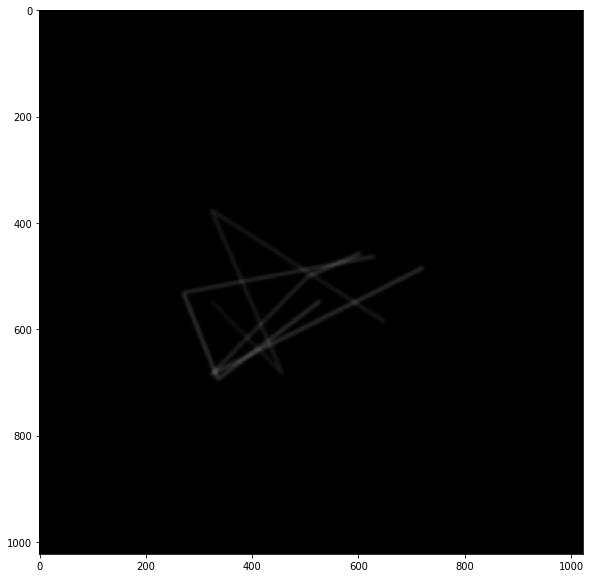

In [10]:
def layer(i):
    res = conv(i, 0)
    for k in range(1, n_images+1):
        if k != i:
            res = res + conv(k, k-i)*dz
    return res

plt.figure(figsize=(10, 10))
plt.imshow(layer(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

In [12]:
def layer(i):
    res = conv(i, 0)
    for k in range(1, n_images+1):
        if k != i:
            res = res + conv(k, k-i)/abs(k-i)
    return res

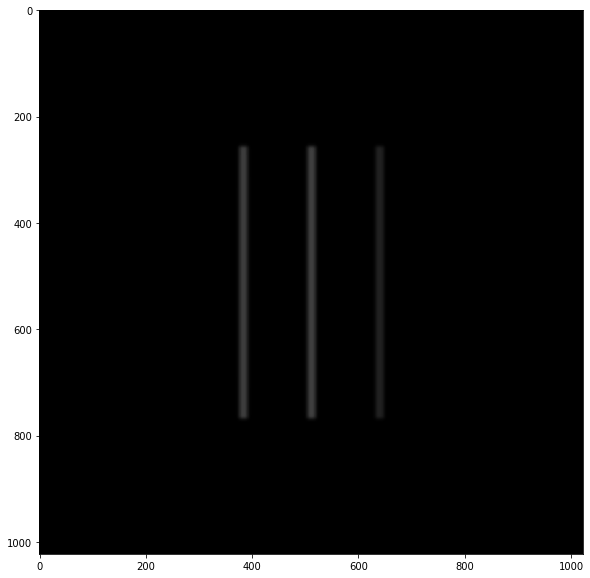

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(layer(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

In [74]:
def layer_F(i):
    res = conv_F(1, (1-i)*dz)*dz
    for k in range(2, n_images+1):
        res = res + conv_F(k, (k-i)*dz)*dz
    return res

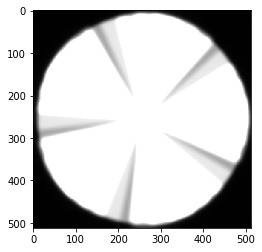

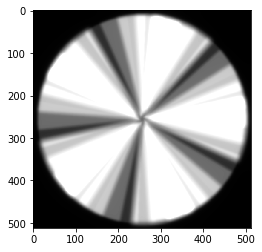

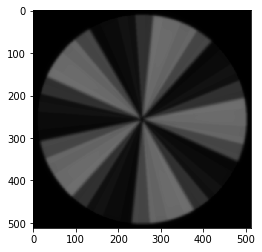

In [70]:
plt.imshow(layer_F(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(layer_F(3), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(layer_F(6), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

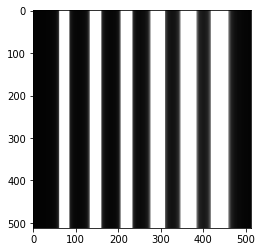

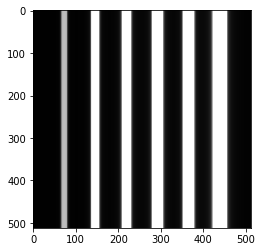

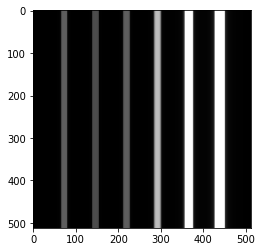

In [75]:
plt.imshow(layer_F(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(layer_F(3), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(layer_F(6), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()